In [1]:
# %run /RiskAndPerformanceIT/prod/Utils/UtilityFunctions


In [2]:
%run ./credential


In [3]:
import DatastreamPy as DSpy
# from pyspark.sql import SparkSession
# from pyspark.sql.functions import col, lag
# from pyspark.sql.window import Window
# from _datetime import datetime
import datetime
from dateutil.relativedelta import relativedelta, WE

import pandas as pd
import numpy as np
pd.DataFrame.iteritems = pd.DataFrame.items


In [4]:
ds = DSpy.DataClient(username=DS_user, password=DS_password)


In [5]:
lists = ['LOPTUPROLC','LOPTUPROLP','LOPTSPXULC','LOPTSPXULP']
meta_list = []
# Retrieve the constituent list
for clist in lists:
  data = ds.get_data(tickers=clist, fields=['RIC','NAME','OXPD'], kind=0)

  meta_list.append(data)
data = pd.concat(meta_list)
# data = data.drop_duplicates(subset=['RIC'])



# Print the list of constituents
# data['Value'].to_list()


In [6]:
data1 = data[data['Datatype']=='RIC']
data2 = data[data['Datatype']=='NAME']
data0 = data[data['Datatype']=='OXPD']
data3 = data1.merge(data2,left_on='Instrument',right_on='Instrument')
data3 = data3[['Instrument','Value_x','Value_y']]
data3.columns = ['Instrument','RIC','NAME']
data3 = data3.merge(data0,left_on='Instrument',right_on='Instrument')
data3 = data3[['Instrument','RIC','NAME','Value']]
data3.columns = ['Instrument','RIC','NAME','EXP']
data3= data3[data3['RIC']!='NA']


In [7]:
data3[['CP','Under','Expire','Strike']] = data3['NAME'].str.split(' ',  expand=True)
data3


,Instrument,RIC,NAME,EXP,CP,Under,Expire,Strike
0,AGBLM3,UPROG182504500.U,CALL UPRO JUL25 45,2025-07-18,CALL,UPRO,JUL25,45
1,AGBLM4,UPROG182505000.U,CALL UPRO JUL25 50,2025-07-18,CALL,UPRO,JUL25,50
2,AGBLM5,UPROG182505500.U,CALL UPRO JUL25 55,2025-07-18,CALL,UPRO,JUL25,55
3,AGBLM6,UPROG182506000.U,CALL UPRO JUL25 60,2025-07-18,CALL,UPRO,JUL25,60
4,AGBLM7,UPROG182506500.U,CALL UPRO JUL25 65,2025-07-18,CALL,UPRO,JUL25,65
...,...,...,...,...,...,...,...,...
1022,AF3PB6,SPXUQ212703000.U,PUT SPXU MAY27 30,2027-05-21,PUT,SPXU,MAY27,30
1023,AF3PB7,SPXUQ212703500.U,PUT SPXU MAY27 35,2027-05-21,PUT,SPXU,MAY27,35
1024,AF175Q,SPXUQ212704000.U,PUT SPXU MAY27 40,2027-05-21,PUT,SPXU,MAY27,40
1029,AF175V,SPXUQ212704500.U,PUT SPXU MAY27 45,2027-05-21,PUT,SPXU,MAY27,45


In [8]:
# data3['Under'].unique()
# Under_mapping = {'DRN':'Bear','DRV$':'Bull'}
# Under_mapping = {'SPXU':'Bear','UPRO':'Bull'}


In [9]:
start_date = datetime.date(datetime.date.today().year, datetime.date.today().month, 1).strftime('%Y-%m-%d')
rics = data3['RIC'].to_list()
ticker = rics

l = len(ticker)
step = 50
n_step = l//step + 1
df_list = []
for i in range(n_step):
  epoch = [f"<{x}>" for x in ticker[i*step:(i+1)*step]]

  # df = updater.ds.get_data(tickers=",".join(epoch), fields=["P"], start=start_date , end=end_date , freq="W")
  df  = ds.get_data(tickers=",".join(epoch), fields=['MP','VL'], start=start_date,kind=1).dropna() #,'PA','PB','MP','STRIKE_PRC','EXPIR_DATE','OXPD'
  df_list.append(df)
df = pd.concat(df_list,axis = 1)

df_p = df.stack(-3).reset_index()
df_p['Instrument'] = df_p['Instrument'].str.strip('<>')
df_p.columns = [x[0] for x in df_p.columns]
df_p


C:\Users\P3004204\AppData\Local\Temp\ipykernel_31376\2488839572.py:17: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_p = df.stack(-3).reset_index()


,Dates,Instrument,MP,VL
0,2025-06-23,SPXU1A162600100.U,2.800,NaN
1,2025-06-23,SPXU1A162600200.U,1.825,NaN
2,2025-06-23,SPXU1A162600300.U,1.275,NaN
3,2025-06-23,SPXU1A162600400.U,0.575,NaN
4,2025-06-23,SPXU1A162600500.U,0.375,NaN
...,...,...,...,...
10397,2025-06-19,UPROX192510500.U,24.250,0.3912
10398,2025-06-19,UPROX192511000.U,28.500,0.3849
10399,2025-06-19,UPROX192511500.U,33.000,0.3783
10400,2025-06-19,UPROX192512000.U,37.700,0.3717


In [10]:
l = len(ticker)
step = 50
n_step = l//step + 1
df_list = []
for i in range(n_step):
  epoch = [f"<{x}>" for x in ticker[i*step:(i+1)*step]]

  # df = updater.ds.get_data(tickers=",".join(epoch), fields=["P"], start=start_date , end=end_date , freq="W")
  df  = ds.get_data(tickers=",".join(epoch), fields=['PA','PB'], start=start_date,kind=1) #,'PA','PB','MP','STRIKE_PRC','EXPIR_DATE','OXPD'
  df_list.append(df)
df = pd.concat(df_list,axis = 1)

df_q = df.stack(-3).reset_index()
df_q['Instrument'] = df_q['Instrument'].str.strip('<>')
df_q.columns = [x[0] for x in df_q.columns]
df_q


C:\Users\P3004204\AppData\Local\Temp\ipykernel_31376\2513341964.py:13: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_q = df.stack(-3).reset_index()


,Dates,Instrument,PA,PB
0,2025-05-30,SPXU1A162600100.U,3.5,2.30
1,2025-05-30,SPXU1A162600200.U,3.7,0.55
2,2025-05-30,SPXU1A162600300.U,2.4,NaN
3,2025-05-30,SPXU1A162600400.U,1.0,NaN
4,2025-05-30,SPXU1A162600500.U,0.6,0.30
...,...,...,...,...
17823,2025-06-27,UPROX192510500.U,20.7,16.60
17824,2025-06-27,UPROX192511000.U,24.4,20.40
17825,2025-06-27,UPROX192511500.U,28.3,24.30
17826,2025-06-27,UPROX192512000.U,32.6,28.60


In [11]:
ds.get_data(tickers="SPXUF202505500.U", fields=['PA','PB'], start=start_date,kind=1)


,Instrument,Datatype,Value,Currency
0,SPXUF202505500.U,PA,"$$ER: E100,INVALID CODE OR EXPRESSION ENTERED",NA
1,SPXUF202505500.U,PB,"$$ER: E100,INVALID CODE OR EXPRESSION ENTERED",NA


In [12]:

df_full = df_p.merge(df_q,on=['Dates','Instrument'],how='outer').merge(data3,left_on='Instrument',right_on='RIC',how='outer')


In [13]:
df_full[df_full['Under']=='SPXU']


,Dates,Instrument_x,MP,VL,PA,PB,Instrument_y,RIC,NAME,EXP,CP,Under,Expire,Strike
0,2025-05-30,SPXU1A162600100.U,2.900,NaN,3.5,2.30,AC4FSC,SPXU1A162600100.U,CALL SPXU JAN26 1,2026-01-16,CALL,SPXU,JAN26,1
1,2025-06-02,SPXU1A162600100.U,2.900,NaN,3.5,2.30,AC4FSC,SPXU1A162600100.U,CALL SPXU JAN26 1,2026-01-16,CALL,SPXU,JAN26,1
2,2025-06-03,SPXU1A162600100.U,2.900,NaN,4.6,1.20,AC4FSC,SPXU1A162600100.U,CALL SPXU JAN26 1,2026-01-16,CALL,SPXU,JAN26,1
3,2025-06-04,SPXU1A162600100.U,2.775,NaN,4.5,1.05,AC4FSC,SPXU1A162600100.U,CALL SPXU JAN26 1,2026-01-16,CALL,SPXU,JAN26,1
4,2025-06-05,SPXU1A162600100.U,2.875,NaN,4.6,1.15,AC4FSC,SPXU1A162600100.U,CALL SPXU JAN26 1,2026-01-16,CALL,SPXU,JAN26,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8189,2025-06-23,SPXUX192504000.U,22.450,0.8306,24.4,20.50,AF6BRG,SPXUX192504000.U,PUT SPXU DEC25 40,2025-12-19,PUT,SPXU,DEC25,40
8190,2025-06-24,SPXUX192504000.U,23.000,0.8412,25.1,20.90,AF6BRG,SPXUX192504000.U,PUT SPXU DEC25 40,2025-12-19,PUT,SPXU,DEC25,40
8191,2025-06-25,SPXUX192504000.U,22.950,0.9193,25.0,20.90,AF6BRG,SPXUX192504000.U,PUT SPXU DEC25 40,2025-12-19,PUT,SPXU,DEC25,40
8192,2025-06-26,SPXUX192504000.U,NaN,NaN,25.0,20.80,AF6BRG,SPXUX192504000.U,PUT SPXU DEC25 40,2025-12-19,PUT,SPXU,DEC25,40


In [14]:
under_p = ds.get_data(tickers="U:SPXU,U:UPRO", fields=['P'], start=start_date,kind=1)
under_p = under_p.stack(-3).reset_index()
under_p.columns = [x[0] for x in under_p.columns]
under_p['Instrument'] = under_p['Instrument'].str.replace('U:','')


C:\Users\P3004204\AppData\Local\Temp\ipykernel_31376\3888288081.py:2: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  under_p = under_p.stack(-3).reset_index()


In [15]:
data_full = df_full.merge(under_p,left_on=['Under','Dates'],right_on=['Instrument','Dates'])


In [16]:
data_full=data_full[['Dates', 'Under', 'P',  'Strike', 'Instrument_x', 'MP', 'VL', 'PA', 'PB',
       'EXP', 'CP']]
data_full


,Dates,Under,P,Strike,Instrument_x,MP,VL,PA,PB,EXP,CP
0,2025-05-30,SPXU,19.58,1,SPXU1A162600100.U,2.900,NaN,3.5,2.30,2026-01-16,CALL
1,2025-06-02,SPXU,19.25,1,SPXU1A162600100.U,2.900,NaN,3.5,2.30,2026-01-16,CALL
2,2025-06-03,SPXU,18.92,1,SPXU1A162600100.U,2.900,NaN,4.6,1.20,2026-01-16,CALL
3,2025-06-04,SPXU,18.96,1,SPXU1A162600100.U,2.775,NaN,4.5,1.05,2026-01-16,CALL
4,2025-06-05,SPXU,19.24,1,SPXU1A162600100.U,2.875,NaN,4.6,1.15,2026-01-16,CALL
...,...,...,...,...,...,...,...,...,...,...,...
18281,2025-06-23,UPRO,84.23,125,UPROX192512500.U,41.100,0.4087,43.2,39.00,2025-12-19,PUT
18282,2025-06-24,UPRO,87.01,125,UPROX192512500.U,38.000,0.3757,40.0,36.00,2025-12-19,PUT
18283,2025-06-25,UPRO,86.95,125,UPROX192512500.U,38.200,0.3800,40.2,36.20,2025-12-19,PUT
18284,2025-06-26,UPRO,88.92,125,UPROX192512500.U,36.200,0.3565,38.2,34.20,2025-12-19,PUT


In [17]:
data_full.rename(columns={'MP':'Option_Price','VL':'IV','P':'Under_Price'},inplace=True)
data_full['Strike'] = data_full['Strike'].astype(float)

# data_full['CP_inverse'] = data_full['CP'].apply(lambda x: 'CALL' if x == 'PUT' else 'PUT')

data_full


,Dates,Under,Under_Price,Strike,Instrument_x,Option_Price,IV,PA,PB,EXP,CP
0,2025-05-30,SPXU,19.58,1.0,SPXU1A162600100.U,2.900,NaN,3.5,2.30,2026-01-16,CALL
1,2025-06-02,SPXU,19.25,1.0,SPXU1A162600100.U,2.900,NaN,3.5,2.30,2026-01-16,CALL
2,2025-06-03,SPXU,18.92,1.0,SPXU1A162600100.U,2.900,NaN,4.6,1.20,2026-01-16,CALL
3,2025-06-04,SPXU,18.96,1.0,SPXU1A162600100.U,2.775,NaN,4.5,1.05,2026-01-16,CALL
4,2025-06-05,SPXU,19.24,1.0,SPXU1A162600100.U,2.875,NaN,4.6,1.15,2026-01-16,CALL
...,...,...,...,...,...,...,...,...,...,...,...
18281,2025-06-23,UPRO,84.23,125.0,UPROX192512500.U,41.100,0.4087,43.2,39.00,2025-12-19,PUT
18282,2025-06-24,UPRO,87.01,125.0,UPROX192512500.U,38.000,0.3757,40.0,36.00,2025-12-19,PUT
18283,2025-06-25,UPRO,86.95,125.0,UPROX192512500.U,38.200,0.3800,40.2,36.20,2025-12-19,PUT
18284,2025-06-26,UPRO,88.92,125.0,UPROX192512500.U,36.200,0.3565,38.2,34.20,2025-12-19,PUT


In [18]:
df_p[df_p['Instrument']=='SPXUF202505500.U']


,Dates,Instrument,MP,VL


In [19]:
data_1 = data_full[data_full['CP'] == 'CALL']
data_2 = data_full[data_full['CP'] == 'PUT']
join_tab = pd.merge(data_1,
                    data_2,how='outer',
                    left_on = ['Dates','Under','EXP','Strike'],
                    right_on = ['Dates','Under','EXP','Strike'])
join_tab['Under_Price_x'] = join_tab['Under_Price_x'].combine_first(join_tab['Under_Price_y'])



In [20]:
join_data1 = join_tab[['Dates', 'Under', 'Under_Price_x', 'Strike', 'EXP', 'Instrument_x_x',
       'Option_Price_x', 'IV_x', 'PA_x', 'PB_x',
       'Instrument_x_y', 'Option_Price_y', 'IV_y', 'PA_y', 'PB_y',]]


join_data1.columns = ['Dates', 'Under', 'Under_Price', 'Strike', 'EXP', 'Instrument_C',
       'Option_Price_C', 'IV_C', 'PA_C', 'PB_C',
       'Instrument_P', 'Option_Price_P', 'IV_P', 'PA_P', 'PB_P']
# join_data1 = join_data1.fillna(0)

join_data1['moneyness'] = join_data1['Strike'].apply(np.log)-join_data1['Under_Price'].apply(np.log)
join_data1['moneyness_inverse'] = join_data1['moneyness'].apply(lambda x: -x)


C:\Users\P3004204\AppData\Local\Temp\ipykernel_31376\1584749180.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  join_data1['moneyness'] = join_data1['Strike'].apply(np.log)-join_data1['Under_Price'].apply(np.log)
C:\Users\P3004204\AppData\Local\Temp\ipykernel_31376\1584749180.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  join_data1['moneyness_inverse'] = join_data1['moneyness'].apply(lambda x: -x)


In [21]:
join_data1.head(20)


,Dates,Under,Under_Price,Strike,EXP,Instrument_C,Option_Price_C,IV_C,PA_C,PB_C,Instrument_P,Option_Price_P,IV_P,PA_P,PB_P,moneyness,moneyness_inverse
0,2025-05-30,SPXU,19.58,10.0,2025-07-18,SPXUG182501000.U,NaN,NaN,11.70,7.60,SPXUS182501000.U,NaN,NaN,0.65,NaN,-0.671924,0.671924
1,2025-05-30,SPXU,19.58,11.0,2025-07-18,SPXUG182501100.U,NaN,NaN,10.70,6.60,SPXUS182501100.U,NaN,NaN,0.65,NaN,-0.576613,0.576613
2,2025-05-30,SPXU,19.58,12.0,2025-07-18,SPXUG182501200.U,NaN,NaN,9.70,5.60,SPXUS182501200.U,NaN,NaN,0.90,NaN,-0.489602,0.489602
3,2025-05-30,SPXU,19.58,13.0,2025-07-18,SPXUG182501300.U,NaN,NaN,8.70,4.60,SPXUS182501300.U,NaN,NaN,2.15,NaN,-0.409559,0.409559
4,2025-05-30,SPXU,19.58,14.0,2025-07-18,SPXUG182501400.U,NaN,NaN,7.70,3.60,SPXUS182501400.U,NaN,NaN,2.15,NaN,-0.335451,0.335451
5,2025-05-30,SPXU,19.58,15.0,2025-07-18,SPXUG182501500.U,NaN,NaN,6.70,2.60,SPXUS182501500.U,NaN,NaN,2.15,NaN,-0.266458,0.266458
6,2025-05-30,SPXU,19.58,16.0,2025-07-18,SPXUG182501600.U,NaN,NaN,5.70,1.60,SPXUS182501600.U,NaN,NaN,2.25,NaN,-0.201920,0.201920
7,2025-05-30,SPXU,19.58,17.0,2025-07-18,SPXUG182501700.U,NaN,NaN,4.60,2.60,SPXUS182501700.U,NaN,NaN,1.35,NaN,-0.141295,0.141295
8,2025-05-30,SPXU,19.58,18.0,2025-07-18,SPXUG182501800.U,NaN,NaN,2.25,1.95,SPXUS182501800.U,NaN,NaN,1.30,0.55,-0.084137,0.084137
9,2025-05-30,SPXU,19.58,19.0,2025-07-18,SPXUG182501900.U,NaN,NaN,2.50,1.45,SPXUS182501900.U,NaN,NaN,1.45,1.20,-0.030070,0.030070


In [22]:
data_1 = join_data1[join_data1['Under'] == 'UPRO']
data_2 = join_data1[join_data1['Under'] == 'SPXU']
join_tab = pd.merge_asof(data_1.sort_values('moneyness'),
                    data_2.sort_values('moneyness_inverse'),
                    left_by=['Dates','EXP'],
                    left_on = ['moneyness'],
                    right_by=['Dates','EXP'],
                    right_on = ['moneyness_inverse'],
                    direction = 'nearest')
join_tab.dropna()


,Dates,Under_x,Under_Price_x,Strike_x,EXP,Instrument_C_x,Option_Price_C_x,IV_C_x,PA_C_x,PB_C_x,...,IV_C_y,PA_C_y,PB_C_y,Instrument_P_y,Option_Price_P_y,IV_P_y,PA_P_y,PB_P_y,moneyness_y,moneyness_inverse_y
2,2025-06-24,UPRO,87.01,20.0,2026-01-16,UPROA162602000.U,67.40,1.0455,69.3,65.5,...,1.0039,0.65,0.45,SPXUM162605500.U,37.650,0.8555,39.60,35.7,1.123091,-1.123091
3,2025-06-25,UPRO,86.95,20.0,2026-01-16,UPROA162602000.U,67.10,0.9539,69.1,65.1,...,0.9726,0.70,0.30,SPXUM162605500.U,37.500,0.9536,39.60,35.4,1.134899,-1.134899
8,2025-06-23,UPRO,84.23,20.0,2026-01-16,UPROA162602000.U,63.80,0.9380,65.0,62.6,...,1.0098,0.85,0.45,SPXUM162605500.U,37.050,0.8216,39.10,35.0,1.090644,-1.090644
17,2025-06-20,UPRO,81.80,20.0,2026-01-16,UPROA162602000.U,62.05,0.9118,64.0,60.1,...,0.9671,0.80,0.45,SPXUM162605500.U,36.650,0.9165,38.70,34.6,1.059741,-1.059741
28,2025-06-24,UPRO,87.01,25.0,2026-01-16,UPROA162602500.U,62.60,0.9373,64.6,60.6,...,1.0039,0.65,0.45,SPXUM162605500.U,37.650,0.8555,39.60,35.7,1.123091,-1.123091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4788,2025-06-25,UPRO,86.95,130.0,2027-01-15,UPROA152713000.U,5.70,0.3731,7.0,4.9,...,0.6677,10.40,5.60,SPXUM152701000.U,2.750,0.8763,5.00,0.5,-0.569849,0.569849
4847,2025-06-23,UPRO,84.23,130.0,2027-01-15,UPROA152713000.U,4.95,0.3618,5.2,4.5,...,0.7518,11.00,6.00,SPXUM152701000.U,1.250,0.5697,2.00,0.5,-0.614104,0.614104
4851,2025-06-24,UPRO,87.01,135.0,2027-01-15,UPROA152713500.U,4.65,0.3546,4.9,4.4,...,0.7890,10.50,5.50,SPXUM152701000.U,1.325,0.5697,2.15,0.5,-0.581657,0.581657
4856,2025-06-25,UPRO,86.95,135.0,2027-01-15,UPROA152713500.U,4.55,0.3515,5.0,4.1,...,0.6677,10.40,5.60,SPXUM152701000.U,2.750,0.8763,5.00,0.5,-0.569849,0.569849


In [23]:
join_tab.to_excel('review1.xlsx')


In [24]:
# from datetime import datetime
# date_string = "AUG25"
# datetime.strptime(date_string, "%b%y").replace( day=15)


In [25]:
join_tab['Expire_Date'] = join_tab['Expire'].apply(lambda x: datetime.datetime.strptime(x, "%b%y").replace( day=15))


KeyError: 'Expire'

In [ ]:

now = datetime.datetime.now()
join_tab['DTE'] = (join_tab['Expire_Date'] - now).dt.days


In [ ]:
import plotly.graph_objects as go


In [ ]:
# fig = go.Figure(data=[go.Surface(z=(join_tab['IV_x']-join_tab['IV_y']).values,x=join_tab['moneyness_x'].values,y=join_tab['IV_x'].values)])
# fig.update_traces(contours_z=dict(show=True, usecolormap=True,
#                                   highlightcolor="limegreen", project_z=True))
# fig.update_layout(title=dict(text='Mt Bruno Elevation'), autosize=False,
#                   scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
#                   width=500, height=500,
#                   margin=dict(l=65, r=50, b=65, t=90)
# )

# fig.show()


In [ ]:
join_tab['Dates'].max()


'2025-06-11'

In [ ]:
import plotly.graph_objects as go
import numpy as np

date_slice = join_tab[(join_tab['Dates'] == join_tab['Dates'].max()) ] #& (join_tab['DTE'] == join_tab['DTE'].min())

x=date_slice['moneyness_x'].values
y=date_slice['DTE'].values
z=(date_slice['IV_x']-date_slice['IV_y']).values
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers')])
fig.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def end_v(under_x=23.97,under_y=66.14,op1_cp='CALL',op2_cp='PUT',op1_k=15.0,op2_k=105,op1_p=9,op2_p=38.8,ratio=3,expire = 'MAY25'):
  x_space = np.linspace(0.5, 2, 100)*under_x
  y_space = np.array([under_x*under_y/x for x in x_space])
  if op1_cp=='CALL':
    op1_pnl = np.maximum(x_space-op1_k,0)-op1_p
  else:
    op1_pnl = np.maximum(op1_k-x_space,0)-op1_p

  if op2_cp=='CALL':
    op2_pnl = np.maximum(y_space-op2_k,0)-op2_p
  else:
    op2_pnl = np.maximum(-y_space +op2_k,0)-op2_p

  pnl = op2_pnl - op1_pnl*ratio

  # Plot the P&L chart
  plt.figure(figsize=(10, 6))
  plt.plot(x_space, op1_pnl, label=f'Option1 SPXU {op1_cp} @{op1_k} P&L - {op1_p}')
  plt.plot(x_space, op2_pnl, label=f'Option2 UPRO {op2_cp} @{op2_k} P&L - {op2_p}')
  plt.plot(x_space, pnl, label='Strategy P&L')
  plt.axhline(0, color='black', linestyle='--')
  plt.axvline(under_x, color='red', linestyle='--', label='Strike Price')
  plt.title(f'P&L Chart, {expire} Ratio ={ratio}')
  plt.xlabel('Stock Price at Expiry')
  plt.ylabel('Profit & Loss')
  plt.legend()
  plt.grid(True)
  plt.show()
# end_v()


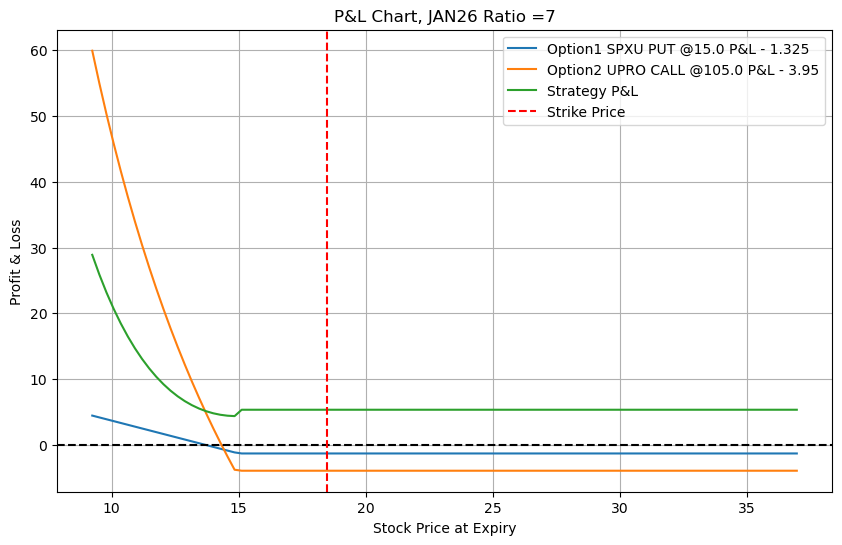

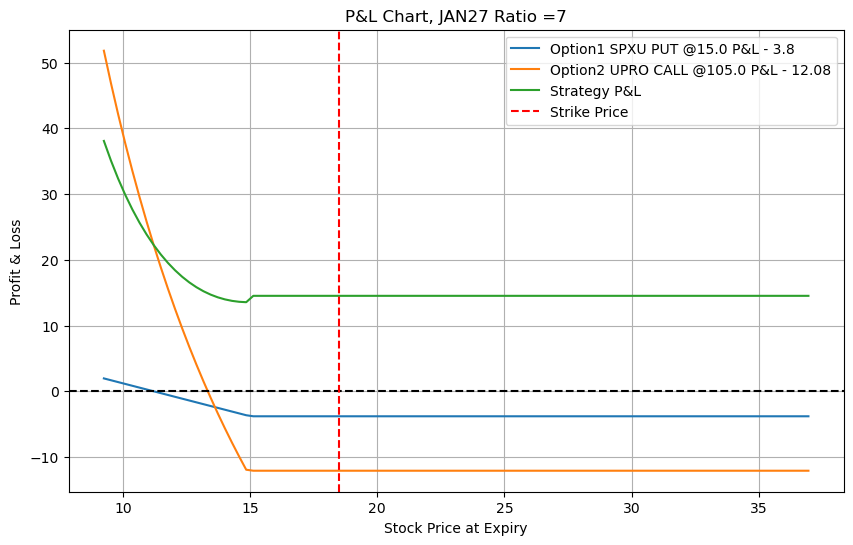

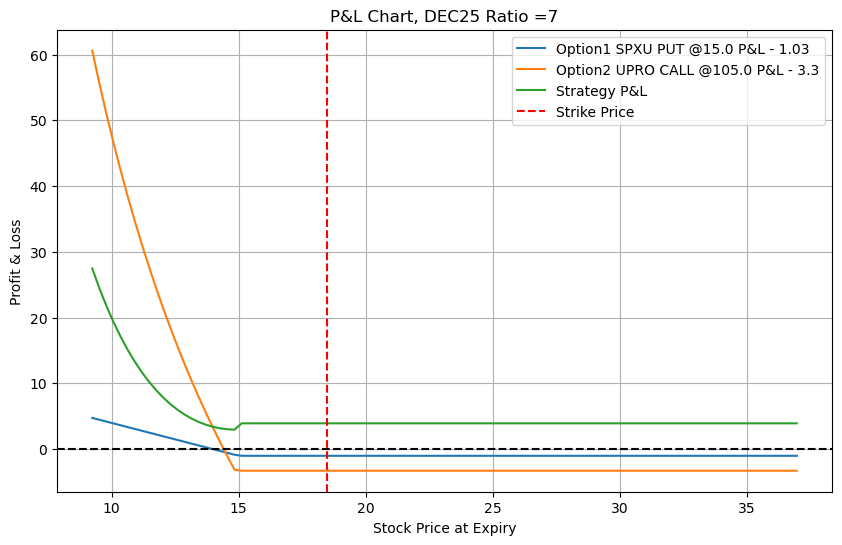

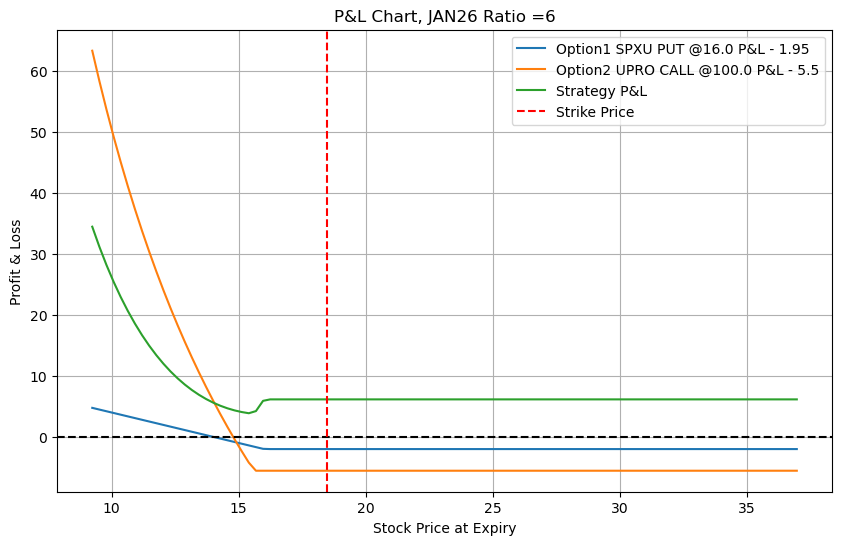

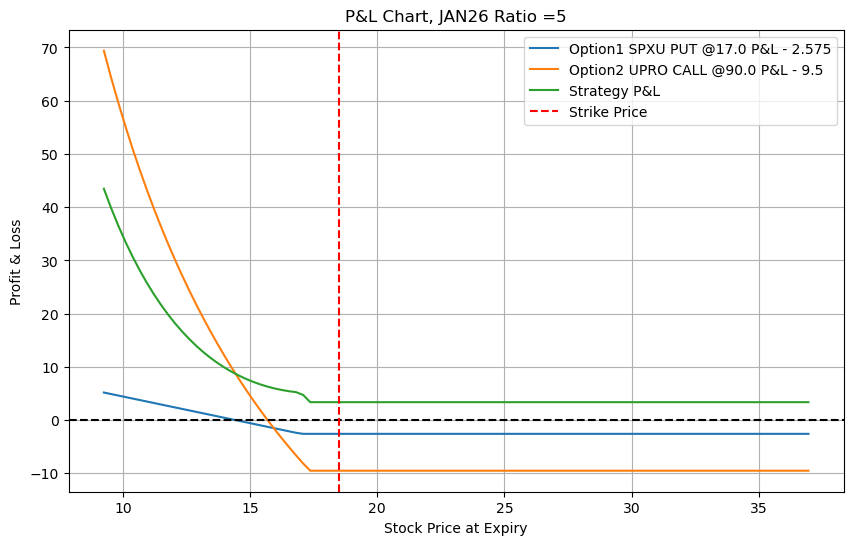

In [ ]:
for i in range(5):

  test = date_slice[((date_slice['IV_x']-date_slice['IV_y']) > 0.10)&(date_slice['moneyness_x']<1.5)&(date_slice['moneyness_x']>-0.5)&(date_slice['CP_x']=='PUT')].iloc[i]
  under_x,under_y,op1_cp,op2_cp,op1_k,op2_k,op1_p,op2_p,expire = test[['Under_Price_x','Under_Price_y','CP_x','CP_y','Strike_x','Strike_y','Option_Price_x','Option_Price_y','Expire']]
  ratio = round(op2_k/op1_k)
  end_v(under_x,under_y,op1_cp,op2_cp,op1_k,op2_k,op1_p,op2_p,ratio,expire)


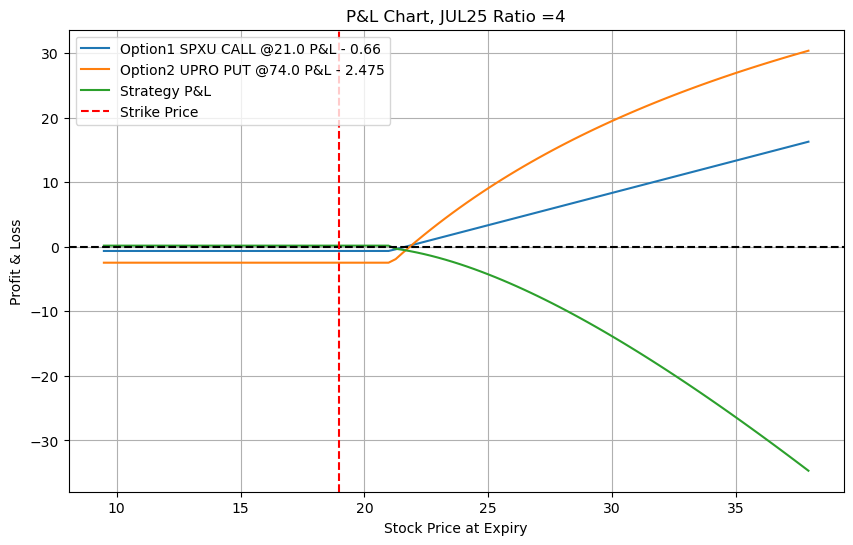

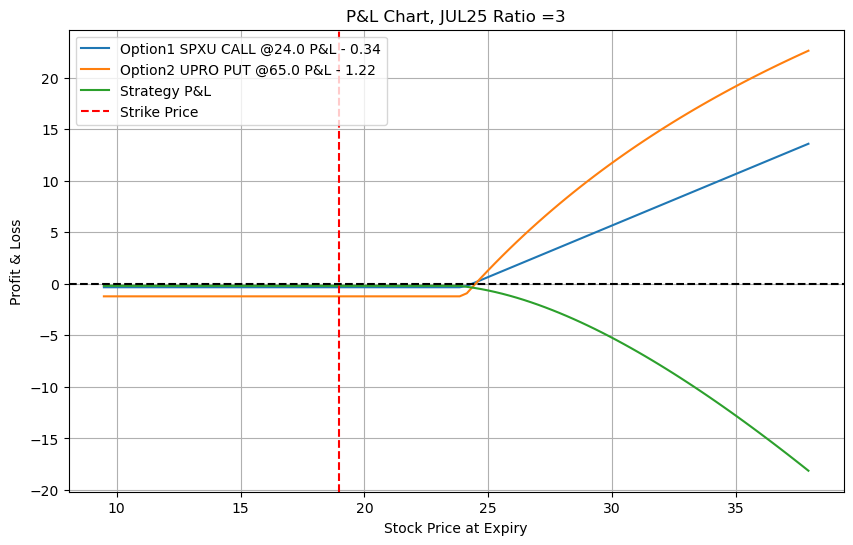

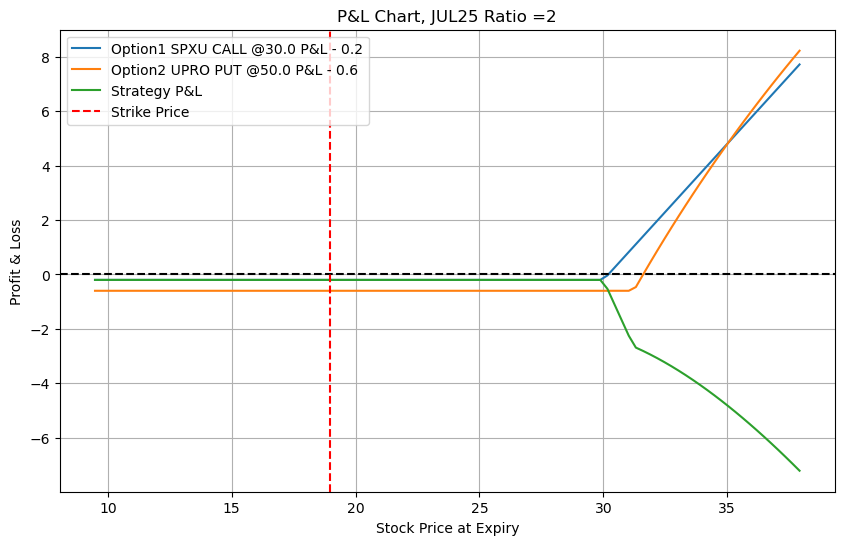

IndexError: single positional indexer is out-of-bounds

In [ ]:
for i in range(5):

  test = date_slice[((date_slice['IV_x']-date_slice['IV_y']) < -0.05)&(date_slice['moneyness_x']<1.8)&(date_slice['moneyness_x']>0.5)&(date_slice['CP_x']=='CALL')].iloc[i]
  under_x,under_y,op1_cp,op2_cp,op1_k,op2_k,op1_p,op2_p,expire = test[['Under_Price_x','Under_Price_y','CP_x','CP_y','Strike_x','Strike_y','Option_Price_x','Option_Price_y','Expire']]
  ratio = round(op2_k/op1_k)
  end_v(under_x,under_y,op1_cp,op2_cp,op1_k,op2_k,op1_p,op2_p,ratio,expire)


In [0]:
date_slice[((date_slice['IV_x']-date_slice['IV_y']) > 0.05)]


Out[87]:

,Dates,Option_Price_x,IV_x,RIC_x,Strike_x,Expire,Under_x,Under_Price_x,CP_x,moneyness_x,CP_inverse_x,moneyness_inverse_x,Option_Price_y,IV_y,RIC_y,Strike_y,Under_y,Under_Price_y,CP_y,moneyness_y,CP_inverse_y,moneyness_inverse_y,Expire_Date,DTE
71,2025-05-02,8.70,0.6961,SPXUA152701500.U,15.0,JAN27,SPXU,22.01,CALL,0.681508,PUT,1.467333,37.85,0.4450,UPROM152710500.U,105.0,UPRO,71.91,PUT,1.460159,CALL,0.684857,2027-01-15,619
72,2025-05-02,7.30,0.6465,SPXUA162601500.U,15.0,JAN26,SPXU,22.01,CALL,0.681508,PUT,1.467333,33.85,0.4066,UPROM162610500.U,105.0,UPRO,71.91,PUT,1.460159,CALL,0.684857,2026-01-15,254
84,2025-05-02,5.95,0.6206,SPXUF202501600.U,16.0,JUN25,SPXU,22.01,CALL,0.726942,PUT,1.375625,26.95,0.5283,UPROR202509900.U,99.0,UPRO,71.91,PUT,1.376721,CALL,0.726364,2025-06-15,40
97,2025-05-02,5.05,0.6015,SPXUF202501700.U,17.0,JUN25,SPXU,22.01,CALL,0.772376,PUT,1.294706,21.05,0.4773,UPROR202509300.U,93.0,UPRO,71.91,PUT,1.293283,CALL,0.773226,2025-06-15,40
98,2025-05-02,8.40,0.7806,SPXUA152701700.U,17.0,JAN27,SPXU,22.01,CALL,0.772376,PUT,1.294706,30.50,0.4582,UPROM152709500.U,95.0,UPRO,71.91,PUT,1.321096,CALL,0.756947,2027-01-15,619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789,2025-05-02,28.95,1.0382,SPXUU192505000.U,50.0,SEP25,SPXU,22.01,PUT,2.271695,CALL,0.440200,43.00,0.9562,UPROI192503000.U,30.0,UPRO,71.91,CALL,0.417188,PUT,2.397000,2025-09-15,132
790,2025-05-02,32.00,0.8742,SPXUM152705000.U,50.0,JAN27,SPXU,22.01,PUT,2.271695,CALL,0.440200,44.62,0.6841,UPROA152703000.U,30.0,UPRO,71.91,CALL,0.417188,PUT,2.397000,2027-01-15,619
791,2025-05-02,1.70,0.9402,SPXUA162605000.U,50.0,JAN26,SPXU,22.01,CALL,2.271695,PUT,0.440200,1.85,0.8883,UPROM162603000.U,30.0,UPRO,71.91,PUT,0.417188,CALL,2.397000,2026-01-15,254
802,2025-05-02,1.59,0.9876,SPXUA162605500.U,55.0,JAN26,SPXU,22.01,CALL,2.498864,PUT,0.400182,1.85,0.8883,UPROM162603000.U,30.0,UPRO,71.91,PUT,0.417188,CALL,2.397000,2026-01-15,254


In [0]:
date_slice


Out[47]:

,Dates,Option_Price_x,IV_x,RIC_x,Strike_x,Expire,Under_x,Under_Price_x,CP_x,moneyness_x,CP_inverse_x,moneyness_inverse_x,Option_Price_y,IV_y,RIC_y,Strike_y,Under_y,Under_Price_y,CP_y,moneyness_y,CP_inverse_y,moneyness_inverse_y,Expire_Date,DTE
600,2025-04-29,0.75,1.5372,SPXUQ162501600.U,16.0,MAY25,SPXU,23.53,PUT,0.679983,CALL,1.470625,0.05,0.7104,UPROE162510000.U,100.0,UPRO,67.4,CALL,1.483680,PUT,0.674000,2025-05-15,14
602,2025-04-29,7.55,1.0863,SPXUE162501600.U,16.0,MAY25,SPXU,23.53,CALL,0.679983,PUT,1.470625,32.50,0.9772,UPROQ162510000.U,100.0,UPRO,67.4,PUT,1.483680,CALL,0.674000,2025-05-15,14
711,2025-04-29,0.75,1.3624,SPXUQ162501700.U,17.0,MAY25,SPXU,23.53,PUT,0.722482,CALL,1.384118,0.03,0.6335,UPROE162509500.U,95.0,UPRO,67.4,CALL,1.409496,PUT,0.709474,2025-05-15,14
716,2025-04-29,6.55,0.8034,SPXUE162501700.U,17.0,MAY25,SPXU,23.53,CALL,0.722482,PUT,1.384118,27.55,0.8745,UPROQ162509500.U,95.0,UPRO,67.4,PUT,1.409496,CALL,0.709474,2025-05-15,14
836,2025-04-29,5.65,0.7884,SPXUE162501800.U,18.0,MAY25,SPXU,23.53,CALL,0.764981,PUT,1.307222,22.55,0.7648,UPROQ162509000.U,90.0,UPRO,67.4,PUT,1.335312,CALL,0.748889,2025-05-15,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4462,2025-04-29,0.35,1.7110,SPXUE162504700.U,47.0,MAY25,SPXU,23.53,CALL,1.997450,PUT,0.500638,0.12,1.5329,UPROQ162503500.U,35.0,UPRO,67.4,PUT,0.519288,CALL,1.925714,2025-05-15,14
4506,2025-04-29,0.35,1.7507,SPXUE162504800.U,48.0,MAY25,SPXU,23.53,CALL,2.039949,PUT,0.490208,0.12,1.5329,UPROQ162503500.U,35.0,UPRO,67.4,PUT,0.519288,CALL,1.925714,2025-05-15,14
4549,2025-04-29,0.40,1.8361,SPXUE162504900.U,49.0,MAY25,SPXU,23.53,CALL,2.082448,PUT,0.480204,0.12,1.5329,UPROQ162503500.U,35.0,UPRO,67.4,PUT,0.519288,CALL,1.925714,2025-05-15,14
4599,2025-04-29,0.35,1.8279,SPXUE162505000.U,50.0,MAY25,SPXU,23.53,CALL,2.124947,PUT,0.470600,0.07,1.8027,UPROQ162503000.U,30.0,UPRO,67.4,PUT,0.445104,CALL,2.246667,2025-05-15,14


Out[48]:

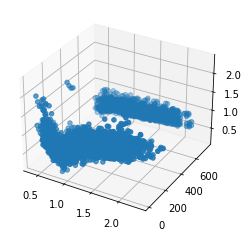

<mpl_toolkits.mplot3d.art3d.Path3DCollection at 0x7f337e4ea130>

In [0]:
import numpy as np
import matplotlib.pyplot as plt

xs = join_tab['moneyness_x']
ys = join_tab['DTE']
zs = join_tab['IV_x']

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(xs, ys, zs)
